## Load Libraries 

In [44]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Dataset : Movielens
https://grouplens.org/datasets/movielens/100k

In [45]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [46]:
df_movies = movies 
df_ratings = ratings 

## Exploratory Data Analysis(EDA)

In [47]:
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Most popular genres of movie released

<BarContainer object of 19 artists>

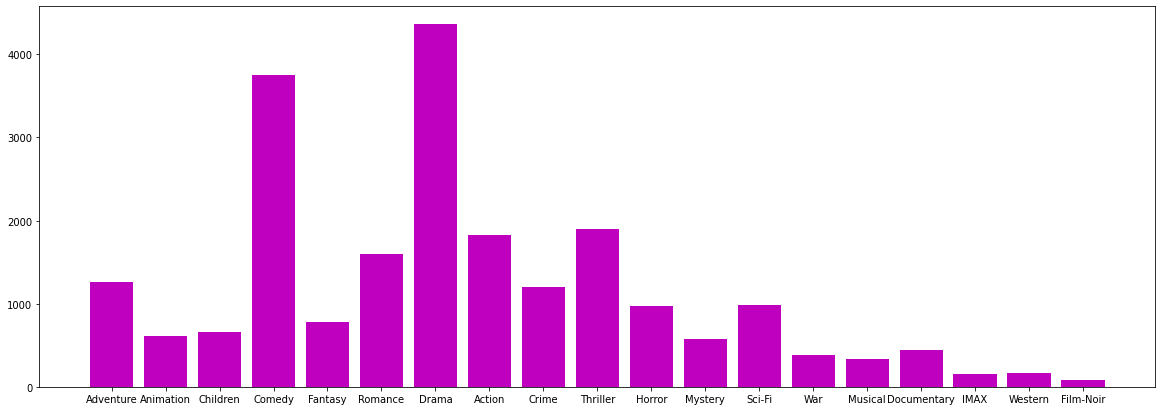

In [48]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='m')

In [49]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Distribution of users rating

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


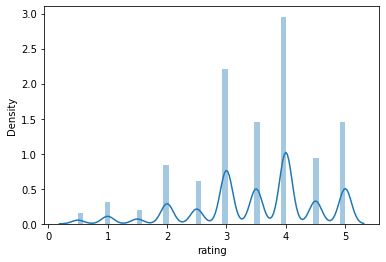

In [50]:
sns.distplot(df_ratings["rating"]);

In [51]:
print("Shape of frames: \n"+ " Rating DataFrame"+ str(df_ratings.shape)+"\n Movies DataFrame"+ str(df_movies.shape))

Shape of frames: 
 Rating DataFrame(100836, 4)
 Movies DataFrame(9742, 3)


In [52]:
merge_ratings_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [53]:
merge_ratings_movies.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962


In [54]:
merge_ratings_movies = merge_ratings_movies.drop('timestamp', axis=1)

In [55]:
merge_ratings_movies.shape

(100836, 5)

Grouping the rating based on user

In [56]:
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])

In [57]:
ratings_grouped_by_users.head(2)

movieId               rating          
          size          mean   size      mean
userId                                       
1          232   1854.603448    232  4.366379
2           29  70350.275862     29  3.948276

In [58]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

### Top 10 users who have rated most of the movies

In [59]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.mean], np.size)

In [60]:
ratings_grouped_by_movies.shape

(9724, 2)

In [61]:
ratings_grouped_by_movies.head(3)

,userId,rating
,mean,mean
movieId,,
1,306.530233,3.920930
2,329.554545,3.431818
3,283.596154,3.259615


In [62]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

### Movies with high average rating

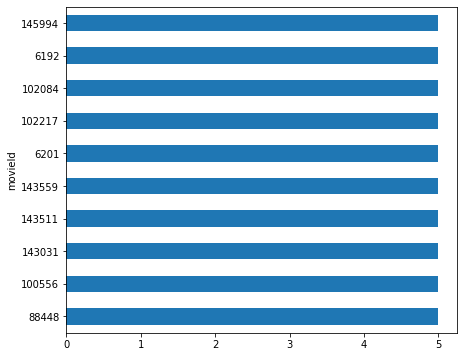

In [63]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(7,6));

### Movies with low average rating

In [64]:
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5

In [65]:
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]

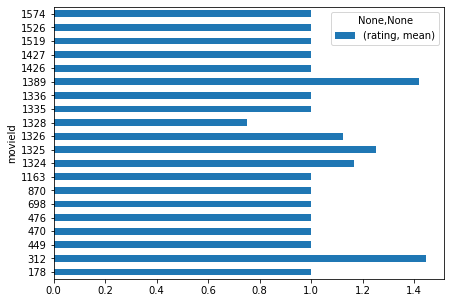

In [66]:
low_rated_movies.head(20).plot(kind='barh', figsize=(7,5));

In [67]:
low_rated_movies.head(10)

,rating
,mean
movieId,
178,1.000000
312,1.444444
449,1.000000
470,1.000000
476,1.000000
698,1.000000
870,1.000000
1163,1.000000


# Content based filtering
The concepts of Term Frequency (TF) and Inverse Document Frequency (IDF) are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

### Term Frequency (TF) and Inverse Document Frequency (IDF)
TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “the rise of analytics” on Google. It is certain that “the” will occur more frequently than “analytics” but the relative importance of analytics is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

We will consider genres as an important parameter to recommend user the movie he watches based on generes of movie user has already watched.

![](https://mungingdata.files.wordpress.com/2017/11/equation.png?w=430&h=336)

For calculating distances, many similarity coefficients can be calculated. Most widely used similarity coefficients are Euclidean, Cosine, Pearson Correlation etc.

**Cosine similarity**
is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.
Given two vectors of attributes, A and B, the cosine similarity, cos(θ), is represented using a dot product and magnitude as
Inline-style: 
![alt text](https://alexn.org/assets/img/cosine-similarity.png)

We will use cosine distance here. Here we are insterested in similarity. That means higher the value more similar they are. But as the function gives us the distance, we will deduct it from 1.

In [68]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
df_movies['genres'] = df_movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(df_movies['genres'])
# print(tfidf_movies_genres.get_feature_names())
# Compute the cosine similarity matrix
# print(tfidf_movies_genres_matrix.shape)
# print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
# print(cosine_sim_movies)

In [69]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = df_movies.loc[df_movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:3]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return df_movies['title'].iloc[movie_indices]


In [70]:
get_recommendations_based_on_genres("Father of the Bride Part II (1995)")

17                        Four Rooms (1995)
18    Ace Ventura: When Nature Calls (1995)
Name: title, dtype: object

In [71]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = df_ratings[df_ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((df_movies["title"][row["movieId"]==df_movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(1)

{'101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 '39 Steps, The (1935)',
 'Ace Ventura: When Nature Calls (1995)',
 'Adventures in Babysitting (1987)',
 'Adventures of Robin Hood, The (1938)',
 'Alamo, The (1960)',
 'Alien Nation (1988)',
 'Amateur (1994)',
 'Amazing Panda Adventure, The (1995)',
 "Antonia's Line (Antonia) (1995)",
 'Antz (1998)',
 'Aristocats, The (1970)',
 'Around the World in 80 Days (1956)',
 'Assassins (1995)',
 'Austin Powers: The Spy Who Shagged Me (1999)',
 'BURN-E (2008)',
 'Babes in Toyland (1934)',
 'Backbeat (1993)',
 'Barb Wire (1996)',
 'Batman: Mystery of the Batwoman (2003)',
 'Beat the Devil (1953)',
 'Before the Rain (Pred dozhdot) (1994)',
 'Ben-Hur (1959)',
 'Big Bully (1996)',
 'Big Country, The (1958)',
 'Big Trouble in Little China (1986)',
 'Black Hole, The (1979)',
 'Blazing Saddles (1974)',
 'Blues Brothers 2000 (1998)',
 'Boot, Das (Boat, The) (1981)',
 'Bride of Frankenstein, The (Bride of Frankenstein) (1935)',
 'Broken Arrow (19

# Model evaluation with KNN
Here the model is evaluated on based of if there is exact match of genres with the genres of movie which is already watch by user 

In [72]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    """
    Get the cluster label to which movie belongs by KNN algorithm.  
    :param movie_id: movie id
    :return: genres label to movie belong
    """
    classifier = KNeighborsClassifier(n_neighbors=5)
    x= tfidf_movies_genres_matrix
    y = df_movies.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [74]:
true_count = 0
false_count = 0
def evaluate_content_based_model():
    """
    Evaluate content based model.  
    """
    for key, colums in df_movies.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
#                 print(colums["genres"])
#                 print(predicted_genre)
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))

Hit:0.9325087251077807
Fault:0.06749127489221926


In [75]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [76]:
df_movies = movies 
df_ratings = ratings 

## Implementation of Item-Item Filtering

In [77]:
df_movies_ratings=pd.merge(df_movies, df_ratings)

In [78]:
df_movies_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


Here Pivot table function is used as we want one to one maping between movies, user and their rating. 
So by default pivot_table command takes average if we have multiple values of one combination.

In [79]:
ratings_matrix_items = df_movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape

(9724, 610)

In [80]:
ratings_matrix_items

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.to_numpy(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items


,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


Below function will take the movie name as a input and will find the movies which are similar to this movie.
This function first find the index of movie in movies frame and then take the similarity of movie and align in movies dataframe so that we can get the similarity of the movie with all other movies.

In [82]:
def item_similarity(movieName): 
    """
    recomendates similar movies
   :param data: name of the movie 
   """
    try:
        #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
        user_inp=movieName
        inp=df_movies[df_movies['title']==user_inp].index.tolist()
        inp=inp[0]

        df_movies['similarity'] = ratings_matrix_items.iloc[inp]
        df_movies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Sorry, the movie is not in the database!")

In [83]:
def recommendedMoviesAsperItemSimilarity(user_id):
    """
     Recommending movie which user hasn't watched as per Item Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user_movie= df_movies_ratings[(df_movies_ratings.userId==user_id) & df_movies_ratings.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    item_similarity(user_movie)
    sorted_movies_as_per_userChoice=df_movies.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    user2Movies= df_ratings[df_ratings['userId']== user_id]['movieId']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= df_ratings[(df_ratings.movieId==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movieId']

In [84]:
def movieIdToTitle(listMovieIDs):
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movie_id']==id]['title'])
    return movie_titles

In [85]:
user_id=50
print("Recommended movies,:\n",movieIdToTitle(recommendedMoviesAsperItemSimilarity(user_id)))

Recommended movies,:
 [659    Godfather, The (1972)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 1644    Willow (1988)
Name: title, dtype: object]


## Implementation of User-Item Filtering

In similar way as we did for ItemItem similarity we will create a matrix but here we will keep rows as user and columns as movieId as we want a vector of different users.
Then in similar ways we will find distance and similarity between users.

In [94]:
ratings_matrix_users = df_movies_ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.to_numpy(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users


,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


Here now we have similarity of users in colums with respective users in row. So if we find maximum value in a column we will get the user with highest similarity. So now we can have a pair of users which are similar.

In [87]:
ratings_matrix_users.idxmax(axis=1)

0         47
1      60756
2        849
3        125
4         58
       ...  
605      232
606      110
607      296
608       10
609        1
Length: 610, dtype: int64

In [88]:
ratings_matrix_users.idxmax(axis=1).sample( 10, random_state = 10 )

547     69
241     32
277     50
348     34
218     50
407    741
352      1
97     356
381     50
607    296
dtype: int64

In [89]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()

In [90]:
df_similar_user.columns=['similarUser']

In [91]:
df_similar_user

,similarUser
0,47
1,60756
2,849
3,125
4,58
...,...
605,232
606,110
607,296
608,10


Below function takes id of the user to whom we have to recommend movies. On basis of that, we find the user which is similar to that user and then filter the movies which are highly rated by the user to recommend them to given user.

In [92]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    """
     Recommending movies which user hasn't watched as per User Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user2Movies= df_ratings[df_ratings['userId']== userId]['movieId']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    for movieId in df_ratings[df_ratings['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= df_movies_ratings[(df_movies_ratings.userId==sim_user) & (df_movies_ratings.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movieId']

In [93]:
user_id=50
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[6268    Half Nelson (2006)
Name: title, dtype: object, 2372    Green Mile, The (1999)
Name: title, dtype: object, 8466    Whiplash (2014)
Name: title, dtype: object, 6444    Reign Over Me (2007)
Name: title, dtype: object, 348    Jason's Lyric (1994)
Name: title, dtype: object, 5885    Crash (2004)
Name: title, dtype: object, 7515    Limitless (2011)
Name: title, dtype: object, 314    Forrest Gump (1994)
Name: title, dtype: object, 6885    Slumdog Millionaire (2008)
Name: title, dtype: object]


# Evaluating the model

In [95]:
def get_user_similar_movies( user1, user2 ):
    
    """
     Returning common movies and ratings of same for both the users
    :param user1,user2: user ids of 2 users need to compare
    :return: movieIds to user 
    """
    common_movies = df_movies_ratings[df_movies_ratings.userId == user1].merge(
      df_movies_ratings[df_movies_ratings.userId == user2],
      on = "movieId",
      how = "inner" )
    common_movies.drop(['movieId','genres_x','genres_y', 'timestamp_x','timestamp_y','title_y'],axis=1,inplace=True)
    return common_movies

In [96]:
get_user_similar_movies(587,511)

,title_x,userId_x,rating_x,userId_y,rating_y
0,Forrest Gump (1994),587,4.0,511,4.5
1,Life Is Beautiful (La Vita Ã¨ bella) (1997),587,5.0,511,4.5
2,"Matrix, The (1999)",587,4.0,511,5.0


## Model-Based Collaborative Filtering

<b>Model-based Collaborative Filtering</b> is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

   * The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.
   * When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.
   * You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

For example, let's check the sparsity of the ratings dataset:

In [108]:
# Import libraries
import numpy as np
import pandas as pd

# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading users file
#users = pd.read_csv('users.dat', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])


In [109]:

n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 610 | Number of movies = 9724


In [110]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
R = Ratings.to_numpy()
#print(R)
user_ratings_mean = np.mean(R, axis = 1)
#print(user_ratings_mean.shape)
print(user_ratings_mean.size)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1) ## Making the user_ratings_mean vertical by reshaping

610


In [114]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens100K dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens100K dataset is 98.3%


A well-known matrix factorization method is Singular value decomposition (SVD). At a high level, SVD is an algorithm that decomposes a matrix $A$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $A$. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:

where $A$ is the input data matrix (users's ratings), $U$ is the left singular vectors (user "features" matrix), $\Sigma$ is the diagonal matrix of singular values (essentially weights/strengths of each concept), and  $V^{T}$ is the right singluar vectors (movie "features" matrix). $U$ and $V^{T}$ are column orthonomal, and represent different things. $U$ represents how much users "like" each feature and $V^{T}$ represents how relevant each feature is to each movie.

To get the lower rank approximation, I take these matrices and keep only the top $k$ features, which can be thought of as the underlying tastes and preferences vectors.

## Setting Up SVD

Scipy and Numpy both have functions to do the singular value decomposition. We are going to use the Scipy function svds because it let’s us choose how many latent factors we want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [104]:
from scipy.sparse.linalg import svds 

In [115]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [116]:
print('Size of sigma: ' , sigma.size)

Size of sigma:  50


As we are going to leverage matrix multiplication to get predictions, we willl convert the $\Sigma$ (now are values) to the diagonal matrix form.

In [117]:
sigma = np.diag(sigma)

In [118]:
print('Shape of sigma: ', sigma.shape)
print(sigma)

Shape of sigma:  (50, 50)
[[ 67.86628347   0.           0.         ...   0.           0.
    0.        ]
 [  0.          68.1967072    0.         ...   0.           0.
    0.        ]
 [  0.           0.          69.02678246 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 184.86187801   0.
    0.        ]
 [  0.           0.           0.         ...   0.         231.22453421
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  474.20606204]]


In [119]:
print('Shape of U: ', U.shape)
print('Shape of Vt: ', Vt.shape)

Shape of U:  (610, 50)
Shape of Vt:  (50, 9724)


## Making Predictions from the Decomposed Matrices

We now have everything we need to make movie ratings predictions for every user. We can do it all at once by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $A$.

But first, we need to add the user means back to get the actual star ratings prediction.

In [128]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [129]:
print('All user predicted rating : ', all_user_predicted_ratings.shape)

All user predicted rating :  (610, 9724)


With the predictions matrix for every user, we can build a function to recommend movies for any user. We return the list of movies the user has already rated, for the sake of comparison.

We will use the column names from the ratings df

In [130]:
print('Rating Dataframe column names', Ratings.columns)

Rating Dataframe column names Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9724)


In [131]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127


Now we write a function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though we didn't use any explicit movie content features (such as genre or title), we will merge in that information to get a more complete picture of the recommendations.

In [138]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    """
    Implementation of SVD by hand
    :param predictions : The SVD reconstructed matrix, 
    userID : UserId for which you want to predict the top rated movies, 
    movies : Matrix with movie data, original_ratings : Original Rating matrix, 
    num_recommendations : num of recos to be returned
    :return: num_recommendations top movies
    """ 
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Let's try to recommend 20 movies for user with ID 150.

In [139]:
already_rated, predictions = recommend_movies(preds, 180, movies, ratings, 20)

User 180 has already rated 24 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [140]:
# Top 20 movies that User 1310 has rated 
already_rated.head(20)

,userId,movieId,rating,timestamp,title,genres
0,180,260,4.5,1270237876,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
7,180,1213,4.5,1270237889,Goodfellas (1990),Crime|Drama
19,180,2959,4.5,1270237884,Fight Club (1999),Action|Crime|Drama|Thriller
23,180,4993,4.5,1270237909,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
4,180,1196,4.0,1270237862,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
5,180,1197,4.0,1270237872,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
6,180,1198,4.0,1270237900,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
3,180,1136,4.0,1270237867,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
21,180,3552,4.0,1270237587,Caddyshack (1980),Comedy
9,180,1261,4.0,1270237636,Evil Dead II (Dead by Dawn) (1987),Action|Comedy|Fantasy|Horror


In [141]:
# Top 20 movies that User 1310 hopefully will enjoy
predictions

,movieId,title,genres
904,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
4776,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
4113,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
275,318,"Shawshank Redemption, The (1994)",Crime|Drama
980,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
256,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
656,858,"Godfather, The (1972)",Crime|Drama
6686,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
895,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi


These look like pretty good recommendations. It's good to see that, although we didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. We have recommended some Action, Adventure, Romance, Thriller movies - all of which were genres of some of this user's top rated movies.